In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost openpyxl tensorflow keras -q

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


In [3]:
# Load the dataset
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')

# Convert date columns
date_columns = ['sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['actual_expedition_date'].min()} to {df['actual_expedition_date'].max()}")
df.head()

Dataset shape: (15297, 25)

Date range: 2023-01-04 15:37:01 to 2025-09-16 00:00:00


,expedition_number,client_order_number,product_name,client_name,postal_code_client,city_client,country_client,sales_order_creation_date,promised_expedition_date,actual_expedition_date,date_and_time_expedition,contract_number,\ntotal_ordered_converted,total_amount_ordered_tm,total_amount_delivered_tm,city_of_delivery,inventory_tag,inventory_location,total_ordered_converted,purchasing_order_number,trucking_company_name,bill_number,cost_of_purchased_order,quantity_of_purchase_order,year
0,231352.0,SO-11118,Huile de Soya,MEUNERIE MARIO BERARD INC,J0E 1E0,ANGE-GARDIEN,canada,2023-01-03,2023-01-03,2023-01-04 15:37:01,NaT,NaN,NaN,3.00,2.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,231353.0,SO-11119,Trituro Laitier - Régulier,FERME QUIKO INC,J0J 1Y0,SAINT-IGNACE-DE-STANBRIDGE,canada,2023-01-03,2023-01-05,2023-01-05 09:16:47,NaT,NaN,NaN,5.00,5.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
2,231356.0,SO-11120,Trituro Laitier - Régulier,LES MOULEES BELLIFRANCE,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-03,2023-01-06,2023-01-05 14:01:47,NaT,NaN,NaN,3.10,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3,231354.0,SO-11120,Trituro Laitier - Régulier,LES MOULEES BELLIFRANCE,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-03,2023-01-06,2023-01-06 12:03:53,NaT,NaN,NaN,4.62,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
4,231355.0,SO-11121,Trituro Laitier - Régulier,SOLLIO AGRICULTURE S.E.C.,G6E 0L9,Sainte-Marie,canada,2023-01-03,2023-01-05,2023-01-05 07:39:39,NaT,NaN,NaN,3.15,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


In [4]:
# Create order size categories
df['order_size_category'] = pd.cut(
    df['total_amount_delivered_tm'],
    bins=[0, 5, 10, 20, np.inf],
    labels=['Small', 'Medium', 'Large', 'Extra Large'],
    include_lowest=True
)

print("Order Size Distribution:")
print(df['order_size_category'].value_counts())
print(f"\nPercentage:")
print(df['order_size_category'].value_counts(normalize=True) * 100)

Order Size Distribution:
order_size_category
Extra Large    7294
Small          3673
Medium         2714
Large          1616
Name: count, dtype: int64

Percentage:
order_size_category
Extra Large    47.682552
Small          24.011244
Medium         17.742041
Large          10.564163
Name: proportion, dtype: float64


In [5]:
# Filter for Small and Medium orders only
df_filtered = df[df['order_size_category'].isin(['Small', 'Medium'])].copy()

print(f"Original dataset: {len(df)} records")
print(f"Filtered dataset (Small + Medium): {len(df_filtered)} records")
print(f"\nCategory breakdown:")
print(df_filtered['order_size_category'].value_counts())

Original dataset: 15297 records
Filtered dataset (Small + Medium): 6387 records

Category breakdown:
order_size_category
Small          3673
Medium         2714
Large             0
Extra Large       0
Name: count, dtype: int64


In [6]:
# Ensure unique SO numbers by deduplicating client_order_number
print(f"Before deduplication: {len(df_filtered)} records")
print(f"Unique client_order_numbers: {df_filtered['client_order_number'].nunique()}")

# Check for duplicates
duplicates = df_filtered['client_order_number'].duplicated().sum()
print(f"Duplicate SO numbers found: {duplicates}")

# Keep only the first occurrence of each client_order_number
# (assuming first record is the most accurate)
df_filtered = df_filtered.drop_duplicates(subset='client_order_number', keep='first')

print(f"After deduplication: {len(df_filtered)} records")
print()

# Sort by client and date
df_filtered = df_filtered.sort_values(['client_name', 'actual_expedition_date'])

# Calculate days since last order for each client
df_filtered['days_since_last_order'] = df_filtered.groupby('client_name')['actual_expedition_date'].diff().dt.days

# Create next order date (target variable)
df_filtered['next_order_date'] = df_filtered.groupby('client_name')['actual_expedition_date'].shift(-1)
df_filtered['days_until_next_order'] = (df_filtered['next_order_date'] - df_filtered['actual_expedition_date']).dt.days

print("Days until next order - Statistics:")
print(df_filtered['days_until_next_order'].describe())



Before deduplication: 6387 records
Unique client_order_numbers: 3734
Duplicate SO numbers found: 2653
After deduplication: 3734 records

Days until next order - Statistics:
count    3537.000000
mean       23.114221
std        47.551775
min         0.000000
25%         2.000000
50%         8.000000
75%        26.000000
max       662.000000
Name: days_until_next_order, dtype: float64


In [7]:
# Client-level features
client_features = df_filtered.groupby('client_name').agg({
    'total_amount_delivered_tm': ['mean', 'std', 'min', 'max', 'count'],
    'days_since_last_order': ['mean', 'std', 'median'],
    'actual_expedition_date': ['min', 'max']
}).reset_index()

client_features.columns = ['_'.join(col).strip('_') for col in client_features.columns.values]
client_features.rename(columns={'client_name': 'client_name'}, inplace=True)

# Calculate client lifetime (days active)
client_features['client_lifetime_days'] = (
    client_features['actual_expedition_date_max'] - client_features['actual_expedition_date_min']
).dt.days

# Calculate order frequency (orders per month)
client_features['order_frequency_per_month'] = (
    client_features['total_amount_delivered_tm_count'] / 
    (client_features['client_lifetime_days'] / 30)
)

print("Client Features Created:")
print(client_features.head())

Client Features Created:
                             client_name  total_amount_delivered_tm_mean  \
0    9252-8405 Quebec INC (FERME TRUDEL)                        5.030000   
1  9377-8454 QUÉBEC INC/ LASHOP AGRICOLE                        1.000000   
2                        AGRI ST-LAURENT                        3.916000   
3                        AGRI-MARCHE INC                        4.093091   
4                  AGRI-SERVICE DMR Inc.                        3.923000   

   total_amount_delivered_tm_std  total_amount_delivered_tm_min  \
0                       0.063770                           4.97   
1                            NaN                           1.00   
2                       1.108989                           2.25   
3                       1.666587                           1.38   
4                       0.843630                           2.42   

   total_amount_delivered_tm_max  total_amount_delivered_tm_count  \
0                           5.09              

In [8]:
# Order-level features
df_features = df_filtered.copy()

# Time-based features
df_features['order_month'] = df_features['actual_expedition_date'].dt.month
df_features['order_quarter'] = df_features['actual_expedition_date'].dt.quarter
df_features['order_day_of_week'] = df_features['actual_expedition_date'].dt.dayofweek
df_features['order_day_of_month'] = df_features['actual_expedition_date'].dt.day
df_features['is_weekend'] = df_features['order_day_of_week'].isin([5, 6]).astype(int)

# Client order sequence
df_features['order_sequence'] = df_features.groupby('client_name').cumcount() + 1

# Recency, Frequency, Monetary (RFM) features
current_date = df_features['actual_expedition_date'].max()
df_features['recency_days'] = (current_date - df_features['actual_expedition_date']).dt.days

# Product-based features
df_features['product_encoded'] = LabelEncoder().fit_transform(df_features['product_name'].fillna('Unknown'))

# Rolling window features (last 3 orders per client)
df_features['rolling_avg_quantity_3'] = df_features.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
df_features['rolling_std_quantity_3'] = df_features.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
).fillna(0)

print(f"\nFeature engineering complete. Total features: {df_features.shape[1]}")
print("\nSample features:")
print(df_features[['client_name', 'order_sequence', 'order_month', 'rolling_avg_quantity_3', 'days_until_next_order']].head(10))


Feature engineering complete. Total features: 39

Sample features:
                                 client_name  order_sequence  order_month  \
11555    9252-8405 Quebec INC (FERME TRUDEL)               1           11   
13681    9252-8405 Quebec INC (FERME TRUDEL)               2            2   
14666    9252-8405 Quebec INC (FERME TRUDEL)               3            6   
15270    9252-8405 Quebec INC (FERME TRUDEL)               4            9   
2669   9377-8454 QUÉBEC INC/ LASHOP AGRICOLE               1            8   
185                          AGRI ST-LAURENT               1            1   
319                          AGRI ST-LAURENT               2            2   
394                          AGRI ST-LAURENT               3            2   
454                          AGRI ST-LAURENT               4            3   
491                          AGRI ST-LAURENT               5            3   

       rolling_avg_quantity_3  days_until_next_order  
11555                4.980000

In [9]:
# Merge client-level features
df_features = df_features.merge(client_features, on='client_name', how='left')

print(f"Dataset shape after merging: {df_features.shape}")
print(f"\nColumns: {df_features.columns.tolist()}")

Dataset shape after merging: (3734, 51)

Columns: ['expedition_number', 'client_order_number', 'product_name', 'client_name', 'postal_code_client', 'city_client', 'country_client', 'sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition', 'contract_number', '\ntotal_ordered_converted', 'total_amount_ordered_tm', 'total_amount_delivered_tm', 'city_of_delivery', 'inventory_tag', 'inventory_location', 'total_ordered_converted', 'purchasing_order_number', 'trucking_company_name', 'bill_number', 'cost_of_purchased_order', 'quantity_of_purchase_order', 'year', 'order_size_category', 'days_since_last_order', 'next_order_date', 'days_until_next_order', 'order_month', 'order_quarter', 'order_day_of_week', 'order_day_of_month', 'is_weekend', 'order_sequence', 'recency_days', 'product_encoded', 'rolling_avg_quantity_3', 'rolling_std_quantity_3', 'total_amount_delivered_tm_mean', 'total_amount_delivered_tm_std', 'total_amount_delivered_tm_min', 

In [10]:
# Remove rows where we don't have a next order (last order for each client)
df_model = df_features[df_features['days_until_next_order'].notna()].copy()

# Remove outliers (optional - orders with extremely long reorder times)
# Keep reorder times within reasonable range (e.g., < 365 days)
df_model = df_model[df_model['days_until_next_order'] <= 365]

print(f"Modeling dataset size: {len(df_model)} records")
print(f"Target variable (days_until_next_order) statistics:")
print(df_model['days_until_next_order'].describe())

Modeling dataset size: 3524 records
Target variable (days_until_next_order) statistics:
count    3524.000000
mean       21.379115
std        37.486807
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max       363.000000
Name: days_until_next_order, dtype: float64


In [11]:
# Select features for modeling
feature_columns = [
    # Order-level features
    'total_amount_delivered_tm',
    'order_sequence',
    'order_month',
    'order_quarter',
    'order_day_of_week',
    'is_weekend',
    'days_since_last_order',
    'product_encoded',
    'rolling_avg_quantity_3',
    'rolling_std_quantity_3',
    
    # Client-level features
    'total_amount_delivered_tm_mean',
    'total_amount_delivered_tm_std',
    'total_amount_delivered_tm_count',
    'days_since_last_order_mean',
    'days_since_last_order_std',
    'client_lifetime_days',
    'order_frequency_per_month'
]

# Create X and y
X = df_model[feature_columns].fillna(0)
y = df_model['days_until_next_order']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {feature_columns}")

Features shape: (3524, 17)
Target shape: (3524,)

Features used: ['total_amount_delivered_tm', 'order_sequence', 'order_month', 'order_quarter', 'order_day_of_week', 'is_weekend', 'days_since_last_order', 'product_encoded', 'rolling_avg_quantity_3', 'rolling_std_quantity_3', 'total_amount_delivered_tm_mean', 'total_amount_delivered_tm_std', 'total_amount_delivered_tm_count', 'days_since_last_order_mean', 'days_since_last_order_std', 'client_lifetime_days', 'order_frequency_per_month']


In [12]:
# Analyze reorder time patterns
print("="*80)
print("REORDER TIME DISTRIBUTION ANALYSIS")
print("="*80)

# Calculate statistics
same_day = (df_model['days_until_next_order'] == 0).sum()
next_day = (df_model['days_until_next_order'] == 1).sum()
within_week = (df_model['days_until_next_order'] <= 7).sum()
long_term = (df_model['days_until_next_order'] > 30).sum()

total = len(df_model)

print(f"\nTotal orders analyzed: {total:,}")
print(f"\nReorder time breakdown:")
print(f"  Same day (0 days):     {same_day:,} orders ({same_day/total*100:.1f}%)")
print(f"  Next day (1 day):      {next_day:,} orders ({next_day/total*100:.1f}%)")
print(f"  Within week (≤7 days): {within_week:,} orders ({within_week/total*100:.1f}%)")
print(f"  Long term (>30 days):  {long_term:,} orders ({long_term/total*100:.1f}%)")



REORDER TIME DISTRIBUTION ANALYSIS

Total orders analyzed: 3,524

Reorder time breakdown:
  Same day (0 days):     573 orders (16.3%)
  Next day (1 day):      225 orders (6.4%)
  Within week (≤7 days): 1,719 orders (48.8%)
  Long term (>30 days):  683 orders (19.4%)


In [13]:
# Analyze same-day reorders by client
same_day_clients = df_model[df_model['days_until_next_order'] == 0].groupby('client_name').size()
same_day_clients = same_day_clients.sort_values(ascending=False)

print(f"\n{'='*80}")
print("SAME-DAY REORDER ANALYSIS (Top 10 Clients)")
print(f"{'='*80}")
print(f"Note: These may be middlemen ordering multiple times for different end clients")
print(f"\nTop 10 clients with most same-day reorders:")
for idx, (client, count) in enumerate(same_day_clients.head(10).items(), 1):
    total_orders = len(df_model[df_model['client_name'] == client])
    print(f"  {idx}. {client[:45]:45s} - {count:3d} same-day reorders ({count/total_orders*100:.0f}% of their orders)")




SAME-DAY REORDER ANALYSIS (Top 10 Clients)
Note: These may be middlemen ordering multiple times for different end clients

Top 10 clients with most same-day reorders:
  1. SOLLIO AGRICULTURE S.E.C.                     - 129 same-day reorders (42% of their orders)
  2. LES ENTREPRISES LAFRANCE DIVISON GRAIN INC    - 125 same-day reorders (36% of their orders)
  3. COVRIS COOPERATIF                             -  83 same-day reorders (56% of their orders)
  4. SOLLIO GROUPE COOPÉRATIF                      -  52 same-day reorders (37% of their orders)
  5. ELEVAGES J. BERTRAND INC                      -  30 same-day reorders (52% of their orders)
  6. UNORIA COOPERATIVE                            -  21 same-day reorders (24% of their orders)
  7. LES MOULEES BELLIFRANCE                       -  21 same-day reorders (25% of their orders)
  8. CARGILL ANIMAL NUTRITION                      -  14 same-day reorders (12% of their orders)
  9. PROREC INC                                    -  13

In [14]:
# Clean infinite and very large values
print("Checking for infinite values...")
print(f"Infinite values before cleaning: {np.isinf(X.values).sum()}")

# Replace inf values with a reasonable maximum
X = X.replace([np.inf, -np.inf], 0)

# Check for any remaining issues
print(f"Infinite values after cleaning: {np.isinf(X.values).sum()}")
print(f"NaN values: {X.isna().sum().sum()}")
print(f"\nData is ready for modeling!")

Checking for infinite values...
Infinite values before cleaning: 1
Infinite values after cleaning: 0
NaN values: 0

Data is ready for modeling!


In [15]:
print("="*80)
print("TRAIN-TEST SPLIT STRATEGY ANALYSIS")
print("="*80)

# OPTION 1: Time-Based Split (Recommended for production)
# Train on older data, test on recent data (simulates real-world deployment)
print("\nOption 1: TIME-BASED SPLIT (Most Realistic)")
print("-" * 60)

# Sort by date
df_model_sorted = df_model.sort_values('actual_expedition_date')
split_point = int(len(df_model_sorted) * 0.8)

train_idx_time = df_model_sorted.index[:split_point]
test_idx_time = df_model_sorted.index[split_point:]

cutoff_date = df_model_sorted.iloc[split_point]['actual_expedition_date']
print(f"Training: Orders before {cutoff_date.date()}")
print(f"Testing:  Orders from {cutoff_date.date()} onwards")
print(f"Train size: {len(train_idx_time)} ({len(train_idx_time)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_time)} ({len(test_idx_time)/len(df_model)*100:.1f}%)")

# OPTION 2: Client-Based Split (Prevents client data leakage)
print("\n\nOption 2: CLIENT-BASED SPLIT (Best Generalization)")
print("-" * 60)

# Get unique clients
unique_clients = df_model['client_name'].unique()
np.random.seed(42)
np.random.shuffle(unique_clients)

split_point_clients = int(len(unique_clients) * 0.8)
train_clients = unique_clients[:split_point_clients]
test_clients = unique_clients[split_point_clients:]

train_idx_client = df_model[df_model['client_name'].isin(train_clients)].index
test_idx_client = df_model[df_model['client_name'].isin(test_clients)].index

print(f"Training: {len(train_clients)} clients, {len(train_idx_client)} orders")
print(f"Testing:  {len(test_clients)} clients, {len(test_idx_client)} orders")
print(f"Train size: {len(train_idx_client)} ({len(train_idx_client)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_client)} ({len(test_idx_client)/len(df_model)*100:.1f}%)")

# OPTION 3: Hybrid - Stratified Client Split (RECOMMENDED)
print("\n\nOption 3: HYBRID SPLIT - Stratified by Client (RECOMMENDED)")
print("-" * 60)
print("Strategy: For each client, use 80% of their orders for training,")
print("          20% of their most recent orders for testing")
print()

# For each client, split their orders chronologically
train_indices_hybrid = []
test_indices_hybrid = []

for client in df_model['client_name'].unique():
    client_orders = df_model[df_model['client_name'] == client].sort_values('actual_expedition_date')
    n_orders = len(client_orders)
    
    if n_orders == 1:
        # If only 1 order, put in training
        train_indices_hybrid.extend(client_orders.index.tolist())
    else:
        # Split: 80% train, 20% test (rounded)
        split_idx = max(1, int(n_orders * 0.8))
        train_indices_hybrid.extend(client_orders.index[:split_idx].tolist())
        test_indices_hybrid.extend(client_orders.index[split_idx:].tolist())

train_idx_hybrid = train_indices_hybrid
test_idx_hybrid = test_indices_hybrid

# Verify client overlap
train_clients_hybrid = df_model.loc[train_idx_hybrid, 'client_name'].unique()
test_clients_hybrid = df_model.loc[test_idx_hybrid, 'client_name'].unique()
overlap_clients = set(train_clients_hybrid).intersection(set(test_clients_hybrid))

print(f"Train size: {len(train_idx_hybrid)} ({len(train_idx_hybrid)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_hybrid)} ({len(test_idx_hybrid)/len(df_model)*100:.1f}%)")
print(f"Clients in training: {len(train_clients_hybrid)}")
print(f"Clients in testing: {len(test_clients_hybrid)}")
print(f"Client overlap: {len(overlap_clients)} (acceptable - testing on future orders)")

# Let user choose the split strategy
print("\n" + "="*80)
print("SELECTING SPLIT STRATEGY")
print("="*80)

# For this analysis, we'll use OPTION 3 (Hybrid) as it's most robust
SPLIT_STRATEGY = 'hybrid'  # Options: 'random', 'time', 'client', 'hybrid'

if SPLIT_STRATEGY == 'time':
    train_idx, test_idx = train_idx_time, test_idx_time
    print("✓ Using TIME-BASED split")
elif SPLIT_STRATEGY == 'client':
    train_idx, test_idx = train_idx_client, test_idx_client
    print("✓ Using CLIENT-BASED split")
elif SPLIT_STRATEGY == 'hybrid':
    train_idx, test_idx = train_idx_hybrid, test_idx_hybrid
    print("✓ Using HYBRID (Time + Client) split")
else:  # random
    train_idx, test_idx = train_test_split(df_model.index, test_size=0.2, random_state=42)
    print("✓ Using RANDOM split (baseline)")

# Create train-test splits
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print(f"\nFinal split: {len(X_train)} train / {len(X_test)} test")

# Verify split integrity
if SPLIT_STRATEGY == 'hybrid':
    train_clients_final = df_model.loc[train_idx, 'client_name'].unique()
    test_clients_final = df_model.loc[test_idx, 'client_name'].unique()
    overlap = set(train_clients_final).intersection(set(test_clients_final))
    print(f"✓ Client overlap: {len(overlap)} clients in both sets")
    print(f"  (Expected for stratified split - testing on future orders)")
elif SPLIT_STRATEGY == 'client':
    train_clients_final = df_model.loc[train_idx, 'client_name'].unique()
    test_clients_final = df_model.loc[test_idx, 'client_name'].unique()
    overlap = set(train_clients_final).intersection(set(test_clients_final))
    print(f"✓ Client overlap check: {len(overlap)} clients (should be 0 for client-based split)")

# Scale features for traditional ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MinMax scaling for LSTM (scales to 0-1 range)
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_minmax.reshape((X_train_minmax.shape[0], 1, X_train_minmax.shape[1]))
X_test_lstm = X_test_minmax.reshape((X_test_minmax.shape[0], 1, X_test_minmax.shape[1]))

print(f"\nScaled data ready:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  LSTM input shape: {X_train_lstm.shape}")

print("\n" + "="*80)
print("Target distribution in training set:")
print(y_train.describe())
print("="*80)

TRAIN-TEST SPLIT STRATEGY ANALYSIS

Option 1: TIME-BASED SPLIT (Most Realistic)
------------------------------------------------------------
Training: Orders before 2025-02-04
Testing:  Orders from 2025-02-04 onwards
Train size: 2819 (80.0%)
Test size:  705 (20.0%)


Option 2: CLIENT-BASED SPLIT (Best Generalization)
------------------------------------------------------------
Training: 117 clients, 2543 orders
Testing:  30 clients, 981 orders
Train size: 2543 (72.2%)
Test size:  981 (27.8%)


Option 3: HYBRID SPLIT - Stratified by Client (RECOMMENDED)
------------------------------------------------------------
Strategy: For each client, use 80% of their orders for training,
          20% of their most recent orders for testing

Train size: 2772 (78.7%)
Test size:  752 (21.3%)
Clients in training: 147
Clients in testing: 127
Client overlap: 127 (acceptable - testing on future orders)

SELECTING SPLIT STRATEGY
✓ Using HYBRID (Time + Client) split

Final split: 2772 train / 752 test
✓ C

In [16]:
# Verify the split quality - show example for one client
print("="*80)
print("SPLIT VERIFICATION - Example Client Analysis")
print("="*80)

# Pick a client with multiple orders (top 5 by order count)
example_client = df_model.groupby('client_name').size().sort_values(ascending=False).head(5).index[0]
client_data = df_model[df_model['client_name'] == example_client].sort_values('actual_expedition_date')

# Check which orders are in train vs test
client_train = client_data.index.isin(train_idx)
client_test = client_data.index.isin(test_idx)

print(f"\nExample Client: {example_client}")
print(f"Total Orders: {len(client_data)}")
print(f"Training Orders: {client_train.sum()}")
print(f"Testing Orders: {client_test.sum()}")

# Dynamic validation based on split strategy
if SPLIT_STRATEGY == 'client':
    # For client-based split, entire client should be in EITHER train OR test
    if client_train.sum() > 0 and client_test.sum() > 0:
        print(f"\n⚠ WARNING: Client has orders in BOTH train and test sets!")
        print(f"  This should NOT happen with client-based splitting")
    elif client_train.sum() > 0:
        train_dates = client_data[client_train]['actual_expedition_date']
        print(f"\nTraining date range: {train_dates.min().date()} to {train_dates.max().date()}")
        print(f"\n✓ Correct: Client is ONLY in training set")
    else:
        test_dates = client_data[client_test]['actual_expedition_date']
        print(f"\nTesting date range:  {test_dates.min().date()} to {test_dates.max().date()}")
        print(f"\n✓ Correct: Client is ONLY in test set (unseen client)")
        
elif SPLIT_STRATEGY in ['time', 'hybrid']:
    # For time-based or hybrid splits, test orders should be after train orders
    train_dates = client_data[client_train]['actual_expedition_date']
    test_dates = client_data[client_test]['actual_expedition_date']
    
    if len(train_dates) > 0:
        print(f"\nTraining date range: {train_dates.min().date()} to {train_dates.max().date()}")
    if len(test_dates) > 0:
        print(f"Testing date range:  {test_dates.min().date()} to {test_dates.max().date()}")
        
    if len(train_dates) > 0 and len(test_dates) > 0:
        if test_dates.min() > train_dates.max():
            print(f"\n✓ Correct: Test orders are AFTER train orders (time-aware)")
        else:
            print(f"\n⚠ WARNING: Some test orders overlap with training period!")
    elif len(test_dates) > 0:
        print(f"\n✓ Correct: Client only has test orders (unseen in training)")
        
else:  # random split
    print(f"\n✓ Random split - no temporal/client guarantees expected")

SPLIT VERIFICATION - Example Client Analysis

Example Client: LES ENTREPRISES LAFRANCE DIVISON GRAIN INC
Total Orders: 352
Training Orders: 281
Testing Orders: 71

Training date range: 2023-09-28 to 2025-05-14
Testing date range:  2025-05-15 to 2025-09-12

✓ Correct: Test orders are AFTER train orders (time-aware)


In [17]:
# Store results for all models
results = []

print("="*80)
print("TRAINING ADVANCED ML MODELS")
print("="*80)

TRAINING ADVANCED ML MODELS


In [18]:
print("\n" + "="*60)
print("Training XGBoost with Hyperparameter Tuning...")
print("="*60)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(
    xgb_model, 
    param_grid_xgb, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Train
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_
print(f"\nBest parameters: {grid_search_xgb.best_params_}")

# Predictions
y_pred_train_xgb = best_xgb.predict(X_train)
y_pred_test_xgb = best_xgb.predict(X_test)

# Evaluate
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"\nTrain MAE: {train_mae_xgb:.2f} days")
print(f"Test MAE: {test_mae_xgb:.2f} days")
print(f"Train RMSE: {train_rmse_xgb:.2f} days")
print(f"Test RMSE: {test_rmse_xgb:.2f} days")
print(f"Train R²: {train_r2_xgb:.4f}")
print(f"Test R²: {test_r2_xgb:.4f}")

# Store results
results.append({
    'Model': 'XGBoost (Tuned)',
    'Train MAE': train_mae_xgb,
    'Test MAE': test_mae_xgb,
    'Train RMSE': train_rmse_xgb,
    'Test RMSE': test_rmse_xgb,
    'Train R²': train_r2_xgb,
    'Test R²': test_r2_xgb
})





Training XGBoost with Hyperparameter Tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Train MAE: 8.41 days
Test MAE: 13.95 days
Train RMSE: 16.84 days
Test RMSE: 33.42 days
Train R²: 0.7652
Test R²: 0.4674


In [19]:
# Add this to verify
train_client_stats = df_model.loc[train_idx].groupby('client_name')['days_until_next_order'].agg(['mean', 'std', 'count'])
test_client_stats = df_model.loc[test_idx].groupby('client_name')['days_until_next_order'].agg(['mean', 'std', 'count'])

print("Training clients - avg std:", train_client_stats['std'].mean())
print("Test clients - avg std:", test_client_stats['std'].mean())

Training clients - avg std: 25.041290048720224
Test clients - avg std: 30.392318391523094


In [20]:
print("\n" + "="*60)
print("Training AdaBoost Regressor...")
print("="*60)

# Define parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Initialize AdaBoost with DecisionTree base estimator
ada_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    random_state=42
)

# Grid search
grid_search_ada = GridSearchCV(
    ada_model,
    param_grid_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Train
grid_search_ada.fit(X_train, y_train)

# Best model
best_ada = grid_search_ada.best_estimator_
print(f"\nBest parameters: {grid_search_ada.best_params_}")

# Predictions
y_pred_train_ada = best_ada.predict(X_train)
y_pred_test_ada = best_ada.predict(X_test)

# Evaluate
train_mae_ada = mean_absolute_error(y_train, y_pred_train_ada)
test_mae_ada = mean_absolute_error(y_test, y_pred_test_ada)
train_rmse_ada = np.sqrt(mean_squared_error(y_train, y_pred_train_ada))
test_rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_test_ada))
train_r2_ada = r2_score(y_train, y_pred_train_ada)
test_r2_ada = r2_score(y_test, y_pred_test_ada)

print(f"\nTrain MAE: {train_mae_ada:.2f} days")
print(f"Test MAE: {test_mae_ada:.2f} days")
print(f"Train RMSE: {train_rmse_ada:.2f} days")
print(f"Test RMSE: {test_rmse_ada:.2f} days")
print(f"Train R²: {train_r2_ada:.4f}")
print(f"Test R²: {test_r2_ada:.4f}")

# Store results
results.append({
    'Model': 'AdaBoost',
    'Train MAE': train_mae_ada,
    'Test MAE': test_mae_ada,
    'Train RMSE': train_rmse_ada,
    'Test RMSE': test_rmse_ada,
    'Train R²': train_r2_ada,
    'Test R²': test_r2_ada
})


Training AdaBoost Regressor...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best parameters: {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 50}

Train MAE: 8.15 days
Test MAE: 14.22 days
Train RMSE: 16.19 days
Test RMSE: 34.11 days
Train R²: 0.7829
Test R²: 0.4452



Training Unidirectional LSTM...

Training LSTM model...
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 22.2139 - mae: 22.2139 - mse: 1872.1174 - val_loss: 9.4140 - val_mae: 9.4140 - val_mse: 239.8941 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0204 - mae: 19.0204 - mse: 1560.4268 - val_loss: 6.6179 - val_mae: 6.6179 - val_mse: 172.7952 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4675 - mae: 16.4675 - mse: 1222.8744 - val_loss: 5.0675 - val_mae: 5.0675 - val_mse: 128.0997 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.1214 - mae: 14.1214 - mse: 916.7582 - val_loss: 4.8075 - val_mae: 4.8075 - val_mse: 113.9299 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8299 - mae: 12.8299 - mse: 792.3626 - val_loss: 4.8511 - val_mae: 4.8511 - val_mse: 110.6358 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

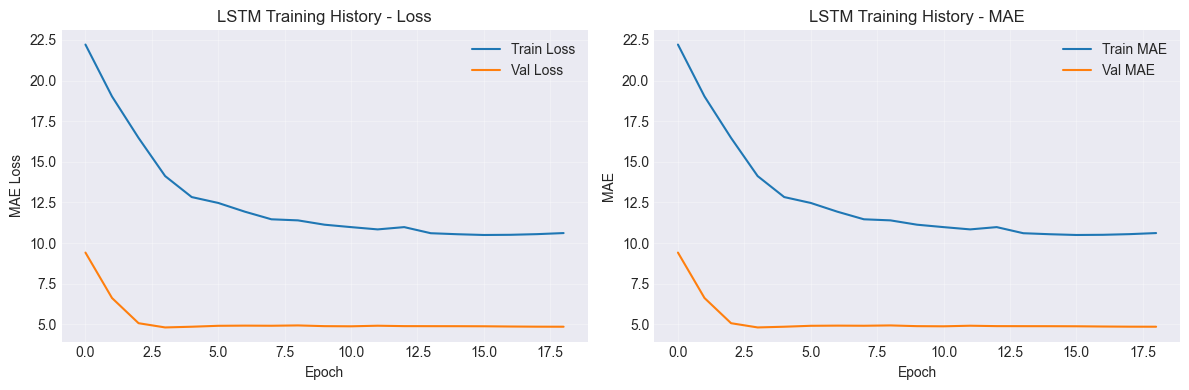

In [21]:
print("\n" + "="*60)
print("Training Unidirectional LSTM...")
print("="*60)

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predictions
y_pred_train_lstm = lstm_model.predict(X_train_lstm, verbose=0).flatten()
y_pred_test_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()

# Evaluate
train_mae_lstm = mean_absolute_error(y_train, y_pred_train_lstm)
test_mae_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
train_rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred_train_lstm))
test_rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
train_r2_lstm = r2_score(y_train, y_pred_train_lstm)
test_r2_lstm = r2_score(y_test, y_pred_test_lstm)

print(f"\nTrain MAE: {train_mae_lstm:.2f} days")
print(f"Test MAE: {test_mae_lstm:.2f} days")
print(f"Train RMSE: {train_rmse_lstm:.2f} days")
print(f"Test RMSE: {test_rmse_lstm:.2f} days")
print(f"Train R²: {train_r2_lstm:.4f}")
print(f"Test R²: {test_r2_lstm:.4f}")

# Store results
results.append({
    'Model': 'LSTM (Unidirectional)',
    'Train MAE': train_mae_lstm,
    'Test MAE': test_mae_lstm,
    'Train RMSE': train_rmse_lstm,
    'Test RMSE': test_rmse_lstm,
    'Train R²': train_r2_lstm,
    'Test R²': test_r2_lstm
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('LSTM Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('LSTM Training History - MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Training Bidirectional LSTM...

Training Bidirectional LSTM model...
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 21.9611 - mae: 21.9611 - mse: 1848.5377 - val_loss: 8.4601 - val_mae: 8.4601 - val_mse: 225.2571 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0667 - mae: 18.0667 - mse: 1428.6193 - val_loss: 5.5038 - val_mae: 5.5038 - val_mse: 159.0672 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2417 - mae: 14.2417 - mse: 977.7974 - val_loss: 4.8174 - val_mae: 4.8174 - val_mse: 111.4296 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.7713 - mae: 12.7713 - mse: 782.4089 - val_loss: 4.8915 - val_mae: 4.8915 - val_mse: 116.4877 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.2783 - mae: 12.2783 - mse: 725.8257 - val_loss: 4.8321 - val_mae: 4.8321 - val_mse: 113.9471 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━

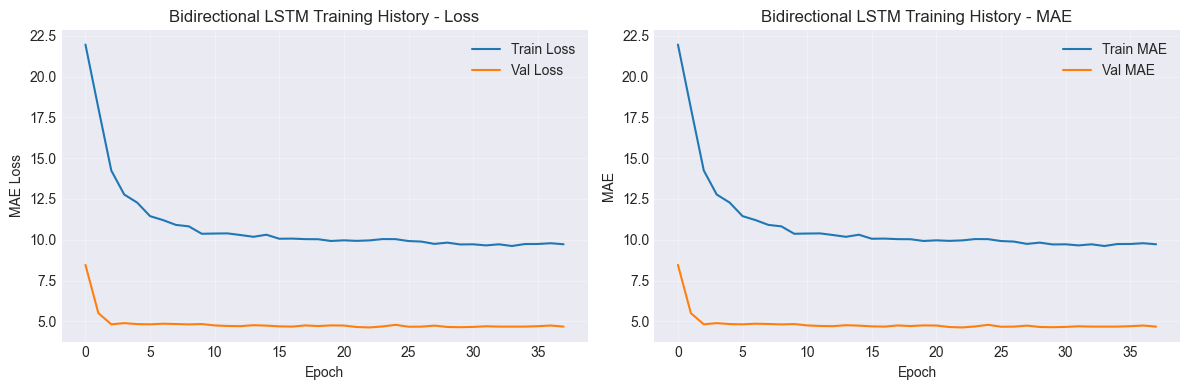

In [22]:
print("\n" + "="*60)
print("Training Bidirectional LSTM...")
print("="*60)

# Build Bidirectional LSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
bilstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping_bi = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_bi = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
print("\nTraining Bidirectional LSTM model...")
history_bilstm = bilstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_bi, reduce_lr_bi],
    verbose=1
)

# Predictions
y_pred_train_bilstm = bilstm_model.predict(X_train_lstm, verbose=0).flatten()
y_pred_test_bilstm = bilstm_model.predict(X_test_lstm, verbose=0).flatten()

# Evaluate
train_mae_bilstm = mean_absolute_error(y_train, y_pred_train_bilstm)
test_mae_bilstm = mean_absolute_error(y_test, y_pred_test_bilstm)
train_rmse_bilstm = np.sqrt(mean_squared_error(y_train, y_pred_train_bilstm))
test_rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_test_bilstm))
train_r2_bilstm = r2_score(y_train, y_pred_train_bilstm)
test_r2_bilstm = r2_score(y_test, y_pred_test_bilstm)

print(f"\nTrain MAE: {train_mae_bilstm:.2f} days")
print(f"Test MAE: {test_mae_bilstm:.2f} days")
print(f"Train RMSE: {train_rmse_bilstm:.2f} days")
print(f"Test RMSE: {test_rmse_bilstm:.2f} days")
print(f"Train R²: {train_r2_bilstm:.4f}")
print(f"Test R²: {test_r2_bilstm:.4f}")

# Store results
results.append({
    'Model': 'Bidirectional LSTM',
    'Train MAE': train_mae_bilstm,
    'Test MAE': test_mae_bilstm,
    'Train RMSE': train_rmse_bilstm,
    'Test RMSE': test_rmse_bilstm,
    'Train R²': train_r2_bilstm,
    'Test R²': test_r2_bilstm
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Bidirectional LSTM Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['mae'], label='Train MAE')
plt.plot(history_bilstm.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Bidirectional LSTM Training History - MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test MAE')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON - ALL ADVANCED MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"Test MAE: {results_df.iloc[0]['Test MAE']:.2f} days")
print(f"Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} days")
print(f"Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"{'='*80}")


FINAL MODEL COMPARISON - ALL ADVANCED MODELS
                Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²
   Bidirectional LSTM   8.445110 13.505495   19.775976  34.685700  0.676161 0.426293
      XGBoost (Tuned)   8.409527 13.945450   16.839030  33.421197  0.765206 0.467360
             AdaBoost   8.146010 14.221944   16.192190  34.109180  0.782898 0.445206
LSTM (Unidirectional)  11.217336 15.362226   25.470020  35.424216  0.462830 0.401602

🏆 BEST MODEL: Bidirectional LSTM
Test MAE: 13.51 days
Test RMSE: 34.69 days
Test R²: 0.4263


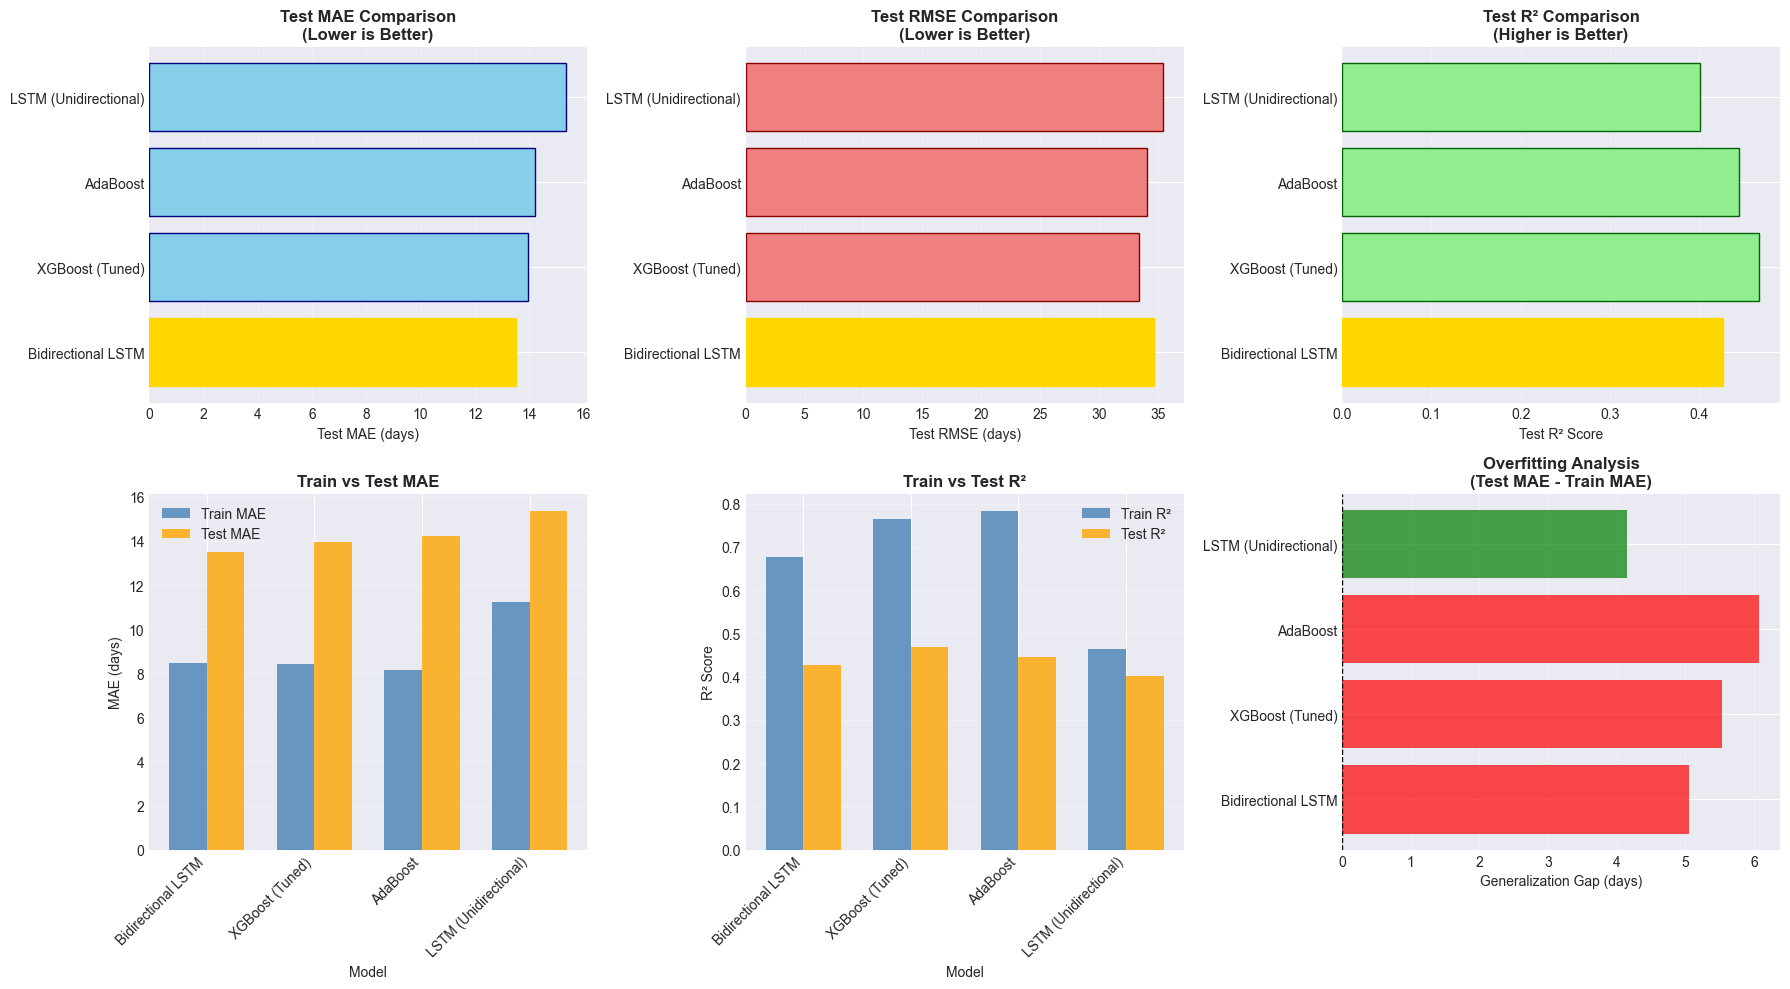

In [24]:
# Comprehensive visualization of model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Test MAE Comparison
ax1 = axes[0, 0]
bars = ax1.barh(results_df['Model'], results_df['Test MAE'], color='skyblue', edgecolor='navy')
bars[0].set_color('gold')  # Highlight best model
ax1.set_xlabel('Test MAE (days)')
ax1.set_title('Test MAE Comparison\n(Lower is Better)', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Test RMSE Comparison
ax2 = axes[0, 1]
bars = ax2.barh(results_df['Model'], results_df['Test RMSE'], color='lightcoral', edgecolor='darkred')
bars[0].set_color('gold')
ax2.set_xlabel('Test RMSE (days)')
ax2.set_title('Test RMSE Comparison\n(Lower is Better)', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Test R² Comparison
ax3 = axes[0, 2]
bars = ax3.barh(results_df['Model'], results_df['Test R²'], color='lightgreen', edgecolor='darkgreen')
bars[0].set_color('gold')
ax3.set_xlabel('Test R² Score')
ax3.set_title('Test R² Comparison\n(Higher is Better)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Train vs Test MAE
ax4 = axes[1, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax4.bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', alpha=0.8, color='steelblue')
ax4.bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', alpha=0.8, color='orange')
ax4.set_xlabel('Model')
ax4.set_ylabel('MAE (days)')
ax4.set_title('Train vs Test MAE', fontweight='bold')
ax4.set_xticks(x_pos) 
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Train vs Test R²
ax5 = axes[1, 1]
ax5.bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', alpha=0.8, color='steelblue')
ax5.bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', alpha=0.8, color='orange')
ax5.set_xlabel('Model')
ax5.set_ylabel('R² Score')
ax5.set_title('Train vs Test R²', fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Overfitting Analysis (Train MAE - Test MAE)
ax6 = axes[1, 2]
overfit_gap = results_df['Test MAE'] - results_df['Train MAE']
colors = ['red' if x > 5 else 'green' for x in overfit_gap]
ax6.barh(results_df['Model'], overfit_gap, color=colors, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Generalization Gap (days)')
ax6.set_title('Overfitting Analysis\n(Test MAE - Train MAE)', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()